<a href="https://colab.research.google.com/github/cfoli/Kinematic-Decoding-4-BCI-Control/blob/main/Two_finger_neural_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mar 14.25.F
from scipy.io import loadmat

file_name = 'MonkeyN_KC' # MonkeyN_MC, MonkeyN_RC, MonkeyW_MC, MonkeyW_RC
file_path = f'/content/drive/MyDrive/ML Projects/Two Finger Neural Decoding/Data/{file_name}.mat'

mat_data = loadmat(file_path)
targ     = mat_data['targ']
targsize = mat_data['targsize']


In [2]:
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'targsize', 'X', 'targ', 'trials', 'y'])

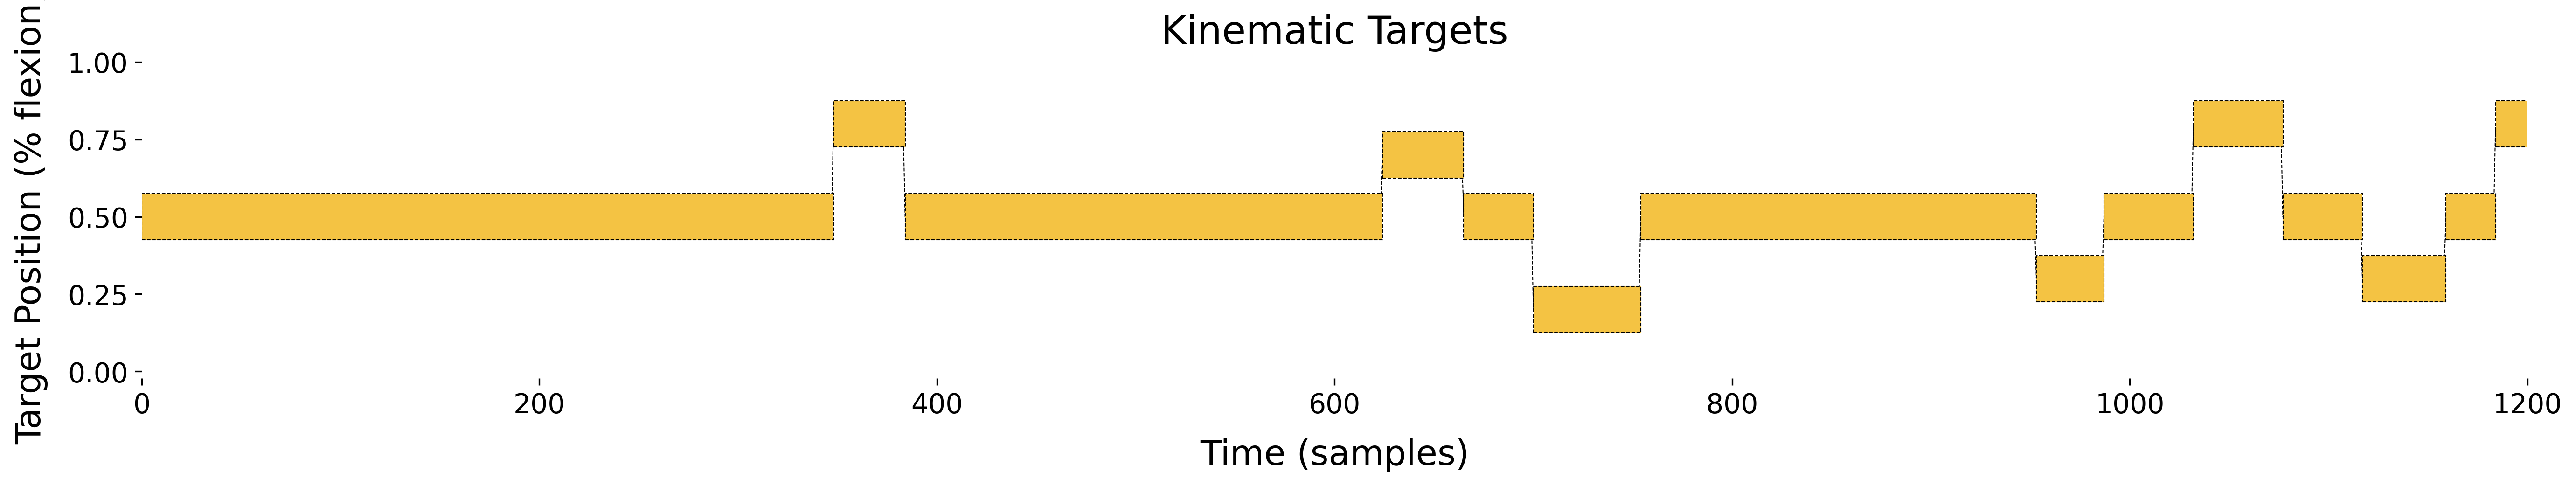

In [65]:
def plot_targets(targ, targsize, fing_color,x_lim=(0,len(targ)),y_pred=None):

  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd

  # Find transitions in target display
  targ_starts = np.concatenate(([0], np.where(np.diff(targ) != 0)[0] + 1))

  # Compute the duration (W) of each target
  targ_durations = np.diff(np.append(targ_starts, len(targ)))  # Ensuring last target is included

  # Compute target heights
  targ_half_height = targsize[targ_starts].flatten()  # Select correct column
  targ_height = 2 * targ_half_height  # Full height = 2 * R
  targ_locs = targ[targ_starts] - targ_half_height  # Compute Y positions

  # Plot the targets as rectangles
  fig, ax = plt.subplots(figsize=(22, 3), dpi=300)
  ax.plot(range(len(targ)), targ, 'k', linewidth=0.5, linestyle='--', zorder=1)  # Plot the target trajectory

  # Draw rectangles
  for i in range(len(targ_starts)):
      rect = plt.Rectangle((targ_starts[i], targ_locs[i]),
                          targ_durations[i], targ_height[i],
                          edgecolor='k', facecolor=fing_color,
                          alpha=1, linestyle='--', linewidth=0.5, zorder=2)
      ax.add_patch(rect)

  if y_pred is not None:
    ax.plot(range(len(y_pred)), y_pred, 'r', linewidth=0.75, linestyle='--', zorder=1)  # Plot the target trajectory

  ax.spines[:].set_visible(False)

  ax.set_xlim(x_lim[0], x_lim[-1])

  # Configure plot
  ax.set_xlabel('Time (samples)',fontsize=18,labelpad=10)
  ax.set_ylabel('Target Position (% flexion)',fontsize=18,labelpad=10)
  ax.set_title('Kinematic Targets',fontsize=20)
  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.grid(False)
  plt.show()

fing = 1  # select finger to plot
fing_color = '#9CEAEF' if fing == 0 else '#F4C343' if fing == 1 else 'k'
plot_targets(targ[:, fing], targsize, fing_color, x_lim=(0,1200))


In [35]:
neural_data = mat_data['X']
neural_data.shape

(14459, 96)

In [63]:
# !pip install lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

fing = 0
X = neural_data.copy()
y = targ[:, fing]

preprocessor = num_pipeline = Pipeline(
    steps = [('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())]
)

# model = Ridge(alpha=0.001, max_iter=1000)
model = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

train_idx = np.round(X.shape[0]*0.8).astype(int)
X_train = X[:train_idx]
y_train = y[:train_idx]
X_test  = X[train_idx:]
y_test  = y[train_idx:]

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

model.fit(X_train_processed, y_train)

# --------------- Evaluate model performance ----------------
y_pred_train = model.predict(X_train_processed)
y_pred_test  = model.predict(X_test_processed)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2   = r2_score(y_train, y_pred_train)
test_r2    = r2_score(y_test, y_pred_test)

from IPython.display import clear_output
clear_output()

print(f"----------- PERFORMANCE METRICS: TRAINING SET ---------------")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")

print(f"----------- PERFORMANCE METRICS: TEST SET ---------------")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²: {test_r2:.4f}")


----------- PERFORMANCE METRICS: TRAINING SET ---------------
Train RMSE: 0.0929
Train R²: 0.7951
----------- PERFORMANCE METRICS: TEST SET ---------------
Test RMSE: 0.1962
Test R²: 0.0932


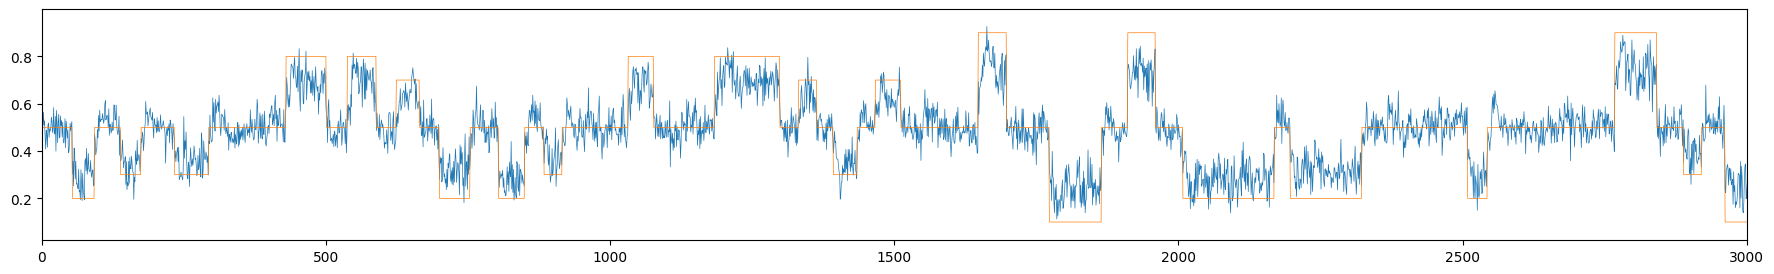

In [64]:

plt.figure(figsize=(22, 3))
plt.plot(y_pred_train,linewidth=0.5)
plt.plot(y_train,linewidth=0.5)
# plt.plot(y_pred_test,linewidth=0.5)
# plt.plot(y_test,linewidth=0.5)
plt.xlim(0,3000)
plt.show()


In [55]:
fing = 1  # select finger to plot
fing_color = '#9CEAEF' if fing == 0 else '#F4C343' if fing == 1 else 'k'
plot_targets(y_train, targsize, fing_color, y_pred = y_pred_train, x_lim=(0,1200))


(11567, 96)